    In this tutorial we will implement the model and inference strategy described in “Attend, Infer, Repeat: Fast Scene Understanding with Generative Models” (AIR) [1] and apply it to the multi-mnist dataset.

In [1]:
%pylab inline
import os
from collections import namedtuple
from observations import multi_mnist
import pyro
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

Populating the interactive namespace from numpy and matplotlib


## Introduction

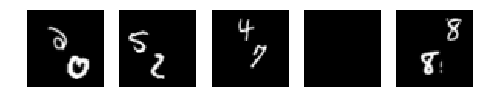

In [2]:
inpath = '../../examples/air/data'
(X_np, _), _ = multi_mnist(inpath, max_digits=2, canvas_size=50, seed=42)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = torch.from_numpy(X_np)
def show_images(imgs):
    figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        subplot(1, len(imgs), i + 1)
        axis('off')
        imshow(img.data.numpy(), cmap='gray')
show_images(mnist[9:14])

    y_att: small image from each step
    z_what: latent "code" variable
    z_where: object's location and size

## Model

### Generating a single object

In [3]:
# Create the neural network. This takes a latent code, z_what, to pixel intensities.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(50, 200)
        self.l2 = nn.Linear(200, 400)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decode = Decoder()

z_where_prior_loc = torch.tensor([3., 0., 0.])
z_where_prior_scale = torch.tensor([0.1, 1., 1.])
z_what_prior_loc = torch.zeros(50)
z_what_prior_scale = torch.ones(50)

def prior_step_sketch(t):
    # Sample object pose. This is a 3-dimensional vector representing x,y position and size.
    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_prior_loc.expand(1, -1),
                                      z_where_prior_scale.expand(1, -1))
                              .independent(1))

    # Sample object code. This is a 50-dimensional vector.
    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_prior_loc.expand(1, -1),
                                     z_what_prior_scale.expand(1, -1))
                             .independent(1))

    # Map code to pixel space using the neural network.
    y_att = decode(z_what)

    # Position/scale object within larger image.
    y = object_to_image(z_where, y_att)

    return y

### STN (spatial transformer network)?

In [4]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = torch.LongTensor([1, 0, 2, 0, 1, 3])
    out = torch.cat((torch.zeros([1, 1]).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

# Takes the small image generated by the neural network and places it within a larger image with the desired pose.
def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

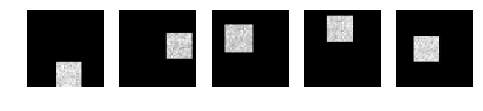

In [5]:
pyro.set_rng_seed(0)
samples = [prior_step_sketch(0)[0] for _ in range(5)]
show_images(samples)

### Generating an entire image

In [6]:
pyro.set_rng_seed(0)
def geom(num_trials=0):
    p = torch.tensor([0.5])
    x = pyro.sample('x{}'.format(num_trials), dist.Bernoulli(p))
    if x[0] == 1:
        return num_trials
    else:
        return geom(num_trials + 1)

# Generate some samples.
for _ in range(5):
    print('sampled {}'.format(geom()))

sampled 2
sampled 3
sampled 0
sampled 1
sampled 0


In [7]:
def geom_prior(x, step=0):
    p = torch.tensor([0.5])
    i = pyro.sample('i{}'.format(step), dist.Bernoulli(p))
    if i[0] == 1:
        return x
    else:
        x = x + prior_step_sketch(step)
        return geom_prior(x, step + 1)

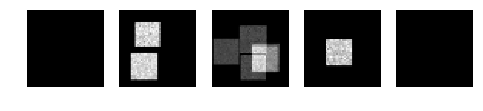

In [8]:
pyro.set_rng_seed(4)
x_empty = torch.zeros(1, 50, 50)
samples = [geom_prior(x_empty)[0] for _ in range(5)]
show_images(samples)

In [9]:
def prior_step(n, t, prev_x, prev_z_pres):

    # Sample variable indicating whether to add this object to the output.

    # We multiply the success probability of 0.5 by the value sampled for this
    # choice in the previous step. By doing so we add objects to the output until
    # the first 0 is sampled, after which we add no further objects.
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(0.5 * prev_z_pres)
                             .independent(1))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_prior_loc.expand(n, -1),
                                      z_where_prior_scale.expand(n, -1))
                              .mask(z_pres)
                              .independent(1))

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_prior_loc.expand(n, -1),
                                     z_what_prior_scale.expand(n, -1))
                             .mask(z_pres)
                             .independent(1))

    y_att = decode(z_what)
    y = object_to_image(z_where, y_att)

    # Combine the image generated at this step with the image so far.
    x = prev_x + y * z_pres.view(-1, 1, 1)

    return x, z_pres

In [10]:
def prior(n):
    x = torch.zeros(n, 50, 50)
    z_pres = torch.ones(n, 1)
    for t in range(3):
        x, z_pres = prior_step(n, t, x, z_pres)
    return x

### Aside: Vectorized mini-batches

In [11]:

def prior_step(n, t, prev_x, prev_z_pres):

    # Sample variable indicating whether to add this object to the output.

    # We multiply the success probability of 0.5 by the value sampled for this
    # choice in the previous step. By doing so we add objects to the output until
    # the first 0 is sampled, after which we add no further objects.
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.Bernoulli(0.5 * prev_z_pres)
                             .independent(1))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.Normal(z_where_prior_loc.expand(n, -1),
                                      z_where_prior_scale.expand(n, -1))
                              .mask(z_pres)
                              .independent(1))

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.Normal(z_what_prior_loc.expand(n, -1),
                                     z_what_prior_scale.expand(n, -1))
                             .mask(z_pres)
                             .independent(1))

    y_att = decode(z_what)
    y = object_to_image(z_where, y_att)

    # Combine the image generated at this step with the image so far.
    x = prev_x + y * z_pres.view(-1, 1, 1)

    return x, z_pres

In [12]:
def prior(n):
    x = torch.zeros(n, 50, 50)
    z_pres = torch.ones(n, 1)
    for t in range(3):
        x, z_pres = prior_step(n, t, x, z_pres)
    return x

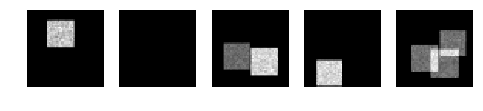

In [13]:
pyro.set_rng_seed(121)
show_images(prior(5))

In [14]:
def model(data):
    # Register network for optimization.
    pyro.module("decode", decode)
    with pyro.iarange('data', data.size(0)) as indices:
        batch = data[indices]
        x = prior(batch.size(0)).view(-1, 50 * 50)
        sd = (0.3 * torch.ones(1)).expand_as(x)
        pyro.sample('obs', dist.Normal(x, sd).independent(1),
                    obs=batch)

## Guide　